# makemore: part 3

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [7]:
# build the dataset
block_size = 8# context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182580, 8]) torch.Size([182580])
torch.Size([22767, 8]) torch.Size([22767])
torch.Size([22799, 8]) torch.Size([22799])


In [8]:
for x,y in zip(Xtr[:20],Ytr[:20]):
   print(''.join(itos[ix.item()] for ix in x)+ ' ----->',itos[y.item()])

........ -----> e
.......e -----> b
......eb -----> r
.....ebr -----> i
....ebri -----> m
...ebrim -----> a
..ebrima -----> .
........ -----> h
.......h -----> i
......hi -----> l
.....hil -----> t
....hilt -----> o
...hilto -----> n
..hilton -----> .
........ -----> j
.......j -----> h
......jh -----> e
.....jhe -----> n
....jhen -----> e
...jhene -----> .


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.0668270587921143
val 2.104844808578491


In [9]:
# SUMMARY + PYTORCHIFYING -----------

In [10]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim==2:
        dim=0
      elif x.ndim==3:
        dim=(0,1)
      
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
#----------------------------------------------------------------------------------------------------------

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
#----------------------------------------------------------------------------------------------------------

class Embedding:
  def __init__(self,num_embeddings,embedding_dim):
    self.weight=torch.randn((num_embeddings,embedding_dim))

  def __call__(self,IX):
    self.out= self.weight[IX]
    return self.out
  
  def parameters(self):
    return [self.weight]


class FlattenConsecutive:
  def __init__(self,n):
    self.n=n

  def __call__(self,x):

    B,T,C= x.shape
    x=x.view(B, T//self.n, C*self.n)
    if x.shape[1]==1:
      x=x.squeeze(1)
    self.out=x
    return self.out
  
  def parameters(self):
    return []

# ------------------------------------------------------------------------------

class Sequential:

  def __init__(self,layers):
    self.layers=layers

  def __call__ (self,x):
    for layer in self.layers:
      x=layer(x)
    self.out=x
    return self.out
  
  def parameters(self):

    return [p for layer in self.layers for p in layer.parameters()]

In [11]:
torch.manual_seed(42)

In [12]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 68 # the number of neurons in the hidden layer of the MLP


model= Sequential([
  Embedding(vocab_size,n_embd),
  FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
])

with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1
 

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

22397


-------------------------------------------------------------------------------------------------------------------

# Practical Playground

In [13]:
ix= torch.randint(0,Xtr.shape[0],(32,))
Xb,Yb=Xtr[ix],Ytr[ix]
logits=model(Xb)
print(Xb.shape)

torch.Size([32, 8])


In [14]:
for layer in model.layers:
    print(layer.
    __class__.__name__,':',tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [19]:
model.layers[0].out.shape,model.layers[0].out

(torch.Size([32, 8, 10]),
 tensor([[[ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          [ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          [ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          ...,
          [ 0.0109, -0.3387, -1.3407,  ...,  0.0516,  0.7440, -0.4816],
          [-1.0495,  0.6039, -1.7223,  ...,  0.4880,  0.7846,  0.0286],
          [-0.0127,  0.2408,  0.1325,  ...,  0.4114,  1.9312,  1.0119]],
 
         [[ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          [ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          [ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
          ...,
          [-0.0127,  0.2408,  0.1325,  ...,  0.4114,  1.9312,  1.0119],
          [-0.2516,  0.8599, -1.3847,  ..., -0.4245,  0.3057, -0.7746],
          [-0.7328,  0.1043,  0.3488,  ..., -0.4175, -1.1955,  0.8123]],
 
         [[ 1.9269,  1.4873,  0.9007,  ..., -1.6047, -0.7521,  1.6487],
  

In [28]:
Xb

tensor([[ 0,  0,  0,  0, 16,  8,  9, 12],
        [ 0,  0,  0, 13,  1, 12,  3, 15],
        [ 0,  0,  0,  8,  5, 18, 13,  5],
        [ 1, 18,  9, 19, 20,  5, 12, 12],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  5, 19, 13,  1],
        [ 0,  0,  0,  0,  0,  0,  4,  5],
        [ 0,  0,  0,  0,  0,  0,  0, 13],
        [ 0,  0,  0,  0,  0,  0,  0, 19],
        [ 0,  0, 18, 21,  5,  7,  5, 18],
        [ 0,  0,  0, 12, 21, 14, 14,  1],
        [ 0,  0,  0,  0,  0,  0,  8, 15],
        [ 0,  0,  0,  8,  1, 23, 23,  1],
        [ 0,  0,  0,  0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0,  0,  0, 11],
        [ 0,  0,  0,  0,  0, 14,  1,  8],
        [ 0,  0,  0,  0,  0,  0,  0, 20],
        [ 0,  0,  0, 10,  8,  5, 12,  1],
        [ 0,  0,  0,  0,  0,  0,  8,  1],
        [ 0,  0,  0,  0,  0, 20,  5,  9],
        [ 0,  0,  0,  0,  0,  0,  0, 23],
        [ 0,  0, 11,  1, 18, 19,  9, 14],
        [ 0,  0,  0,  0,  2, 18,  1,  5],
        [ 0,  0,  0, 12,  9, 14, 2

In [29]:
e=torch.randn(3,8,10)
emean=e.mean(0,keepdim=True)
e


tensor([[[ 1.6811,  0.9196, -0.1452,  0.7939,  0.7806, -0.5958,  0.0962,
           0.6072, -2.1348, -0.6179],
         [ 1.1783, -0.3115,  1.6295, -0.5335, -0.8451, -0.7105, -0.1614,
           0.1468, -0.6465,  1.7719],
         [-0.1940, -1.3313, -0.6194, -0.1997, -0.9896, -1.0748, -0.1746,
           0.5415,  0.4489,  0.5218],
         [-1.1953, -0.0102, -1.5202, -0.7547, -0.4012,  0.1055, -0.4437,
           0.8306, -0.0216,  0.7148],
         [-0.6868,  0.7908,  0.9425, -0.0107,  1.2252,  0.5994, -1.4404,
           0.8617,  0.5880,  1.3349],
         [-0.7089, -0.5003,  1.7600, -0.6248, -1.6466, -0.8005, -2.6546,
          -0.8328,  0.2774,  0.5556],
         [ 0.0994,  1.5964, -1.5129,  0.7811, -0.2720,  1.0166,  1.5994,
           0.0723, -0.4147,  2.6771],
         [ 0.8279,  0.1961, -0.5459, -0.7618, -0.5267,  0.9253, -0.5575,
          -1.1572, -1.4551, -0.8541]],

        [[ 1.0889, -1.2416,  0.3839,  0.3760, -0.2754,  0.8118,  0.5787,
          -0.7361,  0.4087, -0.5638],

--------------------------------------------------------------------------------------------------

In [30]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits= model(Xb)
 
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())



  # if i >= 1000:
  #   break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2991
  10000/ 200000: 2.0042
  20000/ 200000: 2.2487
  30000/ 200000: 2.2309
  40000/ 200000: 2.6951
  50000/ 200000: 2.0993
  60000/ 200000: 1.8203
  70000/ 200000: 1.7755
  80000/ 200000: 1.9377
  90000/ 200000: 1.8271
 100000/ 200000: 2.0159
 110000/ 200000: 1.7789
 120000/ 200000: 1.9555
 130000/ 200000: 2.0804
 140000/ 200000: 2.0185
 150000/ 200000: 2.0426
 160000/ 200000: 1.4640
 170000/ 200000: 1.8538
 180000/ 200000: 1.9945
 190000/ 200000: 1.5760


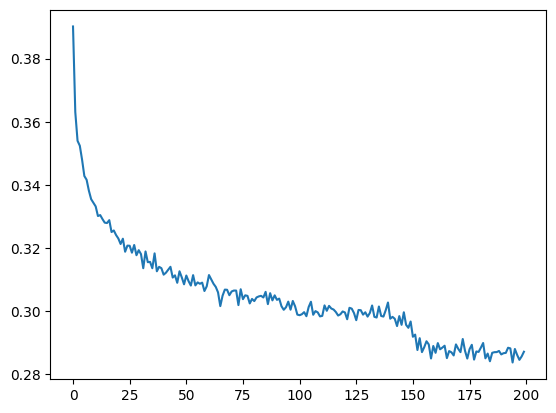

In [31]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [32]:
for layer in model.layers:
    layer.training=False

In [33]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits=model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

# put layers into eval mode
for layer in model.layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.9114603996276855
val 2.019707441329956


In [46]:
for x,y in zip(Xtr[7:14],Ytr[7:14]):
   print(''.join(itos[ix.item()] for ix in x)+ ' ----->',itos[y.item()])

........ -----> h
.......h -----> i
......hi -----> l
.....hil -----> t
....hilt -----> o
...hilto -----> n
..hilton -----> .


In [53]:
Xtr[7].shape

torch.Size([8])

In [55]:
Xtr[[7]].shape

torch.Size([1, 8])

In [70]:
#Forward single example
logits=model(Xtr[[7]])
logits

tensor([[-4.8555,  1.9070,  0.7547,  0.9180,  0.9731,  0.7799, -0.4821, -0.0747,
          0.4174, -0.1544,  1.3219,  1.5258,  0.8277,  1.3918,  0.4646, -0.5782,
         -0.3750, -2.1871,  1.1215,  0.9405,  0.7115, -2.2707, -0.9106, -0.9843,
         -1.7669, -0.3662,  0.1877]], grad_fn=<AddBackward0>)

In [79]:
# Forward all of them 
logits=torch.zeros(8,27)
for i in range(8):
    logits[i]=model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [80]:
logits

tensor([[-4.8555,  1.9070,  0.7547,  0.9180,  0.9731,  0.7799, -0.4821, -0.0747,
          0.4174, -0.1544,  1.3219,  1.5258,  0.8277,  1.3918,  0.4646, -0.5782,
         -0.3750, -2.1871,  1.1215,  0.9405,  0.7115, -2.2707, -0.9106, -0.9843,
         -1.7669, -0.3662,  0.1877],
        [-2.5598,  6.3612, -2.8399, -1.9341, -3.4623,  5.3826, -0.9273, -3.6024,
         -0.5678,  4.1008, -1.7896, -3.0619, -0.1269,  0.0275, -0.0877,  4.7088,
         -1.9263, -3.9405,  2.1972, -1.5999, -1.5426,  4.6757,  0.3489,  1.2764,
         -0.8941,  2.7691, -0.9614],
        [-5.2327,  2.2605,  0.2870, -0.5925,  1.6696,  1.1281, -1.8818,  1.1001,
         -1.9291, -0.8423, -0.9947,  1.6845,  3.0320,  2.3115,  3.1001,  1.6535,
         -1.9504, -1.8145,  2.5947,  0.5499,  0.1760, -3.4032,  1.6250, -3.4217,
         -2.7982,  1.2510,  0.2549],
        [-1.5831,  2.5435,  1.5670,  0.6259,  2.5717,  1.9172, -0.4811, -0.9582,
         -2.4963,  2.4674, -2.5687,  0.2850,  2.8416,  0.3443, -2.2050,  1.7766

### performance log

- original (3 character context + 200 hidden neurons, 12K params): train 2.058, val 2.108
- context: 3 -> 8 (22K params): train 1.918, val 2.027
- wavenet with batchnorm fix : train 1.911, val 2.019


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits=model(torch.tensor([context]))
      
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
mayah.
see.
mad.
rylla.
emmadiendra.
gradered.
eliah.
miloparekelson.
ana.
selyn.
malaia.
noshubergiaghanston.
jowelle.
jetton.
kubrey.
dariyah.
faeh.
yuma.
myson.
